In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, accuracy_score, classification_report
from skopt import BayesSearchCV
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### 1) Data Preperation
* Dropped salary columns because salary is something that is present after the recruitment.
* One hot encoded necessary categorical attributes.

In [2]:
# Read the original data
placement_data = pd.read_csv("../data/Placement_Data_Full_Class.csv")
placement_data

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,Placed,400000.0
211,212,M,58.00,Others,60.00,Others,Science,72.00,Sci&Tech,No,74.0,Mkt&Fin,53.62,Placed,275000.0
212,213,M,67.00,Others,67.00,Others,Commerce,73.00,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,Placed,295000.0
213,214,F,74.00,Others,66.00,Others,Commerce,58.00,Comm&Mgmt,No,70.0,Mkt&HR,60.23,Placed,204000.0


In [3]:
# Convert status into a binary column
def convert_status(row):
    placement_status = row["status"]
    is_placed = 0
    if placement_status == "Placed":
        is_placed = 1
    return is_placed

placement_data["is_placed"] = placement_data.apply(convert_status, axis=1)
placement_data.drop(columns="status", inplace=True)
placement_data

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,is_placed
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,270000.0,1
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,200000.0,1
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,250000.0,1
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,NaN,0
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,425000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,400000.0,1
211,212,M,58.00,Others,60.00,Others,Science,72.00,Sci&Tech,No,74.0,Mkt&Fin,53.62,275000.0,1
212,213,M,67.00,Others,67.00,Others,Commerce,73.00,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,295000.0,1
213,214,F,74.00,Others,66.00,Others,Commerce,58.00,Comm&Mgmt,No,70.0,Mkt&HR,60.23,204000.0,1


In [4]:
# One hot encode categorical attributes for model creation:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop(columns=feature_to_encode)
    return(res)

placement_df = placement_data.drop(columns=["salary", "sl_no"])
features_to_encode = ["gender", "ssc_b", "hsc_b", "hsc_s", "degree_t", "workex", "specialisation"]
for feature in features_to_encode:
    placement_df = encode_and_bind(placement_df, feature)

placement_df = placement_df.drop(columns=["workex_No", "gender_F", "ssc_b_Others", "hsc_b_Others", "specialisation_Mkt&HR"]) # DROP Binary Columns
placement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ssc_p                   215 non-null    float64
 1   hsc_p                   215 non-null    float64
 2   degree_p                215 non-null    float64
 3   etest_p                 215 non-null    float64
 4   mba_p                   215 non-null    float64
 5   is_placed               215 non-null    int64  
 6   gender_M                215 non-null    uint8  
 7   ssc_b_Central           215 non-null    uint8  
 8   hsc_b_Central           215 non-null    uint8  
 9   hsc_s_Arts              215 non-null    uint8  
 10  hsc_s_Commerce          215 non-null    uint8  
 11  hsc_s_Science           215 non-null    uint8  
 12  degree_t_Comm&Mgmt      215 non-null    uint8  
 13  degree_t_Others         215 non-null    uint8  
 14  degree_t_Sci&Tech       215 non-null    ui

### 2) Split the data into train and test
* Used test size = 0.2
* Printed out #0 / #1

In [5]:
X = placement_df.drop(columns="is_placed")
y = placement_df.is_placed.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
print('#0/#1 is {}'.format((len(y)-sum(y))/sum(y)))

#0/#1 is 0.4527027027027027


### 3) Model Creation Using XGBoost
* Used Bayesian Seach with 5 folded cross-validation for hyper parameter tuning.
* Average precision score is used.
* Final model is created with the best hyperparameters.

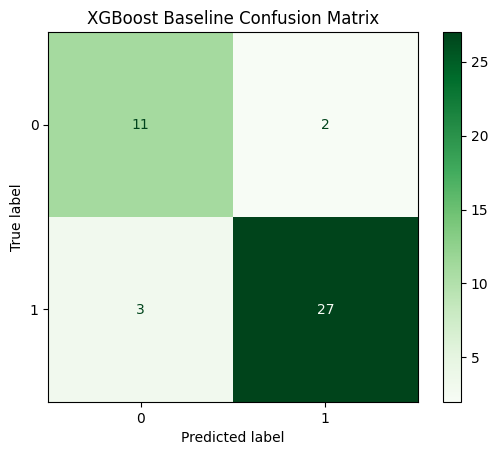

In [6]:
xgb_baseline = xgb.XGBClassifier(
    objective='binary:logistic',
    booster='gbtree',
    eval_metric='auc',
    scale_pos_weight=0.45
)

xgb_baseline.fit(X_train, y_train)

plot_confusion_matrix(xgb_baseline, X_test, y_test, cmap="Greens")
plt.title("XGBoost Baseline Confusion Matrix")
plt.show()

In [7]:
# xgboost model
xgb0 = xgb.XGBClassifier(
    objective='binary:logistic',
    booster='gbtree',
    eval_metric='auc',
    scale_pos_weight=0.45
)

In [8]:
# HYPER PARAMETER TUNING
param_grid = {'xgb__gamma':[0.2, 0.4, 0.8, 1.2],
              'xgb__learning_rate':[0.05, 0.1, 0.15, 0.2],
              'xgb__max_delta_step':[0, 5, 10, 15],
              'xgb__max_depth':[6, 8, 10, 12, 13],
              'xgb__n_estimators':[100, 120, 140, 160, 180, 200, 220],
              'xgb__subsample':[0.18, 0.2, 0.22],
              'xgb__colsample_bynode':[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'xgb__colsample_bytree':[0.6, 0.7, 0.8, 0.9],
              'xgb__reg_alpha':[0, 0.1, 0.2, 0.4, 0.8],
              'xgb__reg_lambda':[0, 0.1, 0.2, 0.4, 0.8],}

gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]
bcvj = int(gcvj)

model = BayesSearchCV(estimator=xgb0, search_spaces=param_grid, n_iter=100, scoring='average_precision', cv=5, return_train_score=True, verbose=3)
model.fit(X_train, y_train)

df = pd.DataFrame(model.cv_results_)
bp = model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:00:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__colsample_bynode", "xgb__colsample_bytree", "xgb__gamma", "xgb__learning_rate", "xgb__max_delta_step", "xgb__max_depth", "xgb__n_estimators", "xgb__reg_alpha", "xgb__reg_lambda", "xgb__subsample" } are not used.

[CV 1/5] END xgb__colsample_bynode=0.9, xgb__colsample_bytree=0.9, xgb__gamma=0.8, xgb__learning_rate=0.1, xgb__max_delta_step=5, xgb__max_depth=8, xgb__n_estimators=140, xgb__reg_alpha=0.8, xgb__reg_lambda=0.4, xgb__subsample=0.2;, score=(train=1.000, test=0.935) total time=   0.0s
[12:00:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__colsample_bynode", "xgb__colsample_bytree", "xgb__gamma", "xgb__learning_rate", "xgb__max_delta_step", "xgb__max_depth", "xg

In [9]:
sorted_df = df.sort_values(by='rank_test_score')
bp

OrderedDict([('xgb__colsample_bynode', 0.9),
             ('xgb__colsample_bytree', 0.9),
             ('xgb__gamma', 0.8),
             ('xgb__learning_rate', 0.1),
             ('xgb__max_delta_step', 5),
             ('xgb__max_depth', 8),
             ('xgb__n_estimators', 140),
             ('xgb__reg_alpha', 0.8),
             ('xgb__reg_lambda', 0.4),
             ('xgb__subsample', 0.2)])

In [10]:
# Hyperparameter tuned final model

tuned_model = xgb.XGBClassifier(objective='binary:logistic',
                            booster='gbtree',
                            eval_metric='auc',
                            colsample_bynode=bp["xgb__colsample_bynode"],
                            colsample_bytree=bp["xgb__colsample_bytree"],
                            gamma=bp["xgb__gamma"],
                            learning_rate=bp["xgb__learning_rate"],
                            max_delta_step=bp["xgb__max_delta_step"],
                            max_depth=bp["xgb__max_depth"],
                            n_estimators=bp["xgb__n_estimators"],
                            reg_alpha=bp["xgb__reg_alpha"],
                            reg_lambda=bp["xgb__reg_lambda"],
                            subsample=bp["xgb__subsample"],
                            scale_pos_weight=0.45
                            )

tuned_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=0.9, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.8, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=5,
              max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=140, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

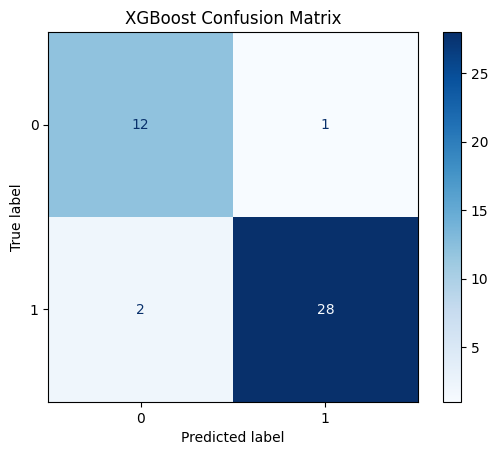

In [11]:
plot_confusion_matrix(tuned_model, X_test, y_test, cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

### 4) Model Creation Using Random Forest
* Used Bayesian Seach with 5 folded cross-validation for hyper parameter tuning.
* Average precision score is used.
* Final model is created with the best hyperparameters.

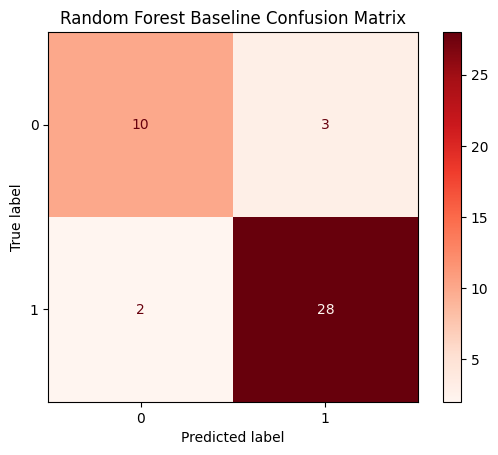

In [12]:
# Baseline model

rf_baseline = RandomForestClassifier()
rf_baseline.fit(X_train, y_train)

plot_confusion_matrix(rf_baseline, X_test, y_test, cmap="Reds")
plt.title("Random Forest Baseline Confusion Matrix")
plt.show()

In [13]:
#random forest model
rf0 = RandomForestClassifier()

# HYPER PARAMETER TUNING
param_grid_rf = {
    'n_estimators':[100, 120, 140, 160, 180, 200, 220],
    'criterion':["gini", "entropy", "log_loss"],
    'max_depth':[6, 8, 10, 12, 14],
    'max_features':[5, 6, 8, 10, 12]
}

gcvj = np.cumsum([len(x) for x in param_grid_rf.values()])[-1]
bcvj = int(gcvj)

model = BayesSearchCV(estimator=rf0, search_spaces=param_grid_rf, n_iter=100, scoring='average_precision', cv=5, return_train_score=True, verbose=3)
model.fit(X_train, y_train)

rf_df = pd.DataFrame(model.cv_results_)
rf_bp = model.best_params_


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=12, max_features=10, n_estimators=180;, score=(train=1.000, test=0.923) total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=12, max_features=10, n_estimators=180;, score=(train=1.000, test=0.986) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=12, max_features=10, n_estimators=180;, score=(train=1.000, test=0.962) total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=12, max_features=10, n_estimators=180;, score=(train=1.000, test=0.887) total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=12, max_features=10, n_estimators=180;, score=(train=1.000, test=0.987) total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=log_loss, max_depth=12, max_features=10, n_estimators=180;, score=(train=1.000, test=0.915) total time=   0.2s
[CV 2/5] END criterion=log_loss, max_depth=12, max_features=10, n_estimators=180;, score=(train=1.

In [14]:
rf_sorted_df = rf_df.sort_values(by='rank_test_score')
rf_bp

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 10),
             ('max_features', 5),
             ('n_estimators', 160)])

In [15]:
# Hyperparameter tuned final model

rf_tuned_model = RandomForestClassifier(
    n_estimators=rf_bp["n_estimators"],
    criterion=rf_bp["criterion"],
    max_depth=rf_bp["max_depth"],
    max_features=rf_bp["max_features"]
)

rf_tuned_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=5,
                       n_estimators=160)

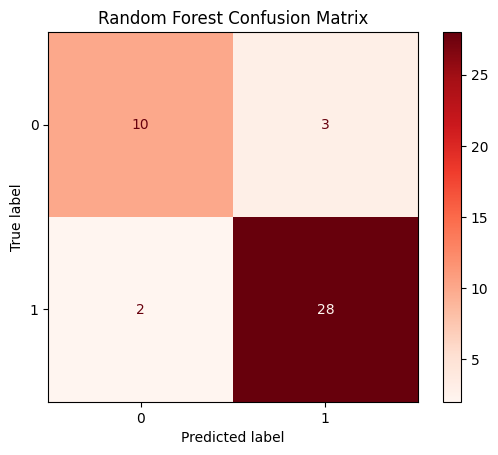

In [16]:
plot_confusion_matrix(rf_tuned_model, X_test, y_test, cmap="Reds")
plt.title("Random Forest Confusion Matrix")
plt.show()

### 5) Model Comparision
* Detailed comparision between tuned XGBoost model and tuned Random Forest model

#### 5.1) Confusion Matrices

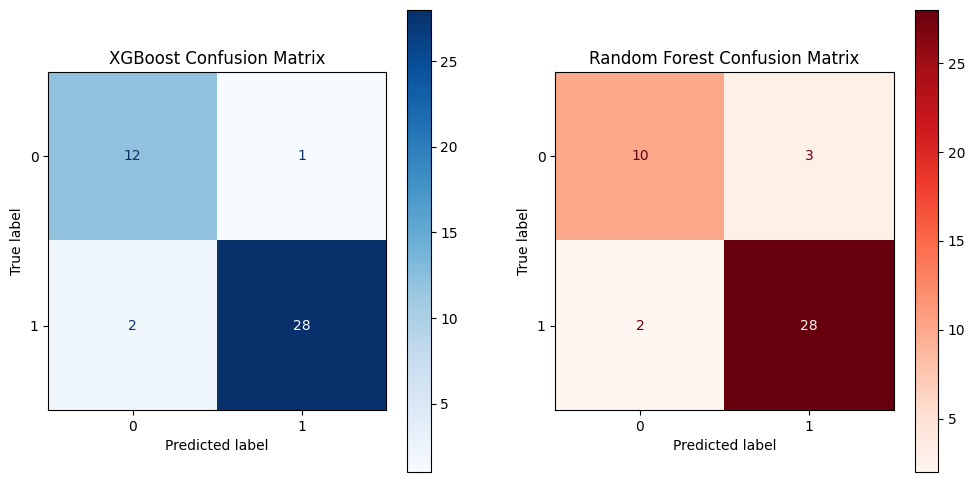

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrices:
plot_confusion_matrix(tuned_model, X_test, y_test, cmap="Blues", ax=axs[0])
plot_confusion_matrix(rf_tuned_model, X_test, y_test, cmap="Reds", ax=axs[1])
axs[0].set_title("XGBoost Confusion Matrix")
axs[1].set_title("Random Forest Confusion Matrix")
plt.show()

#### 5.2) ROC and Precision-Recall

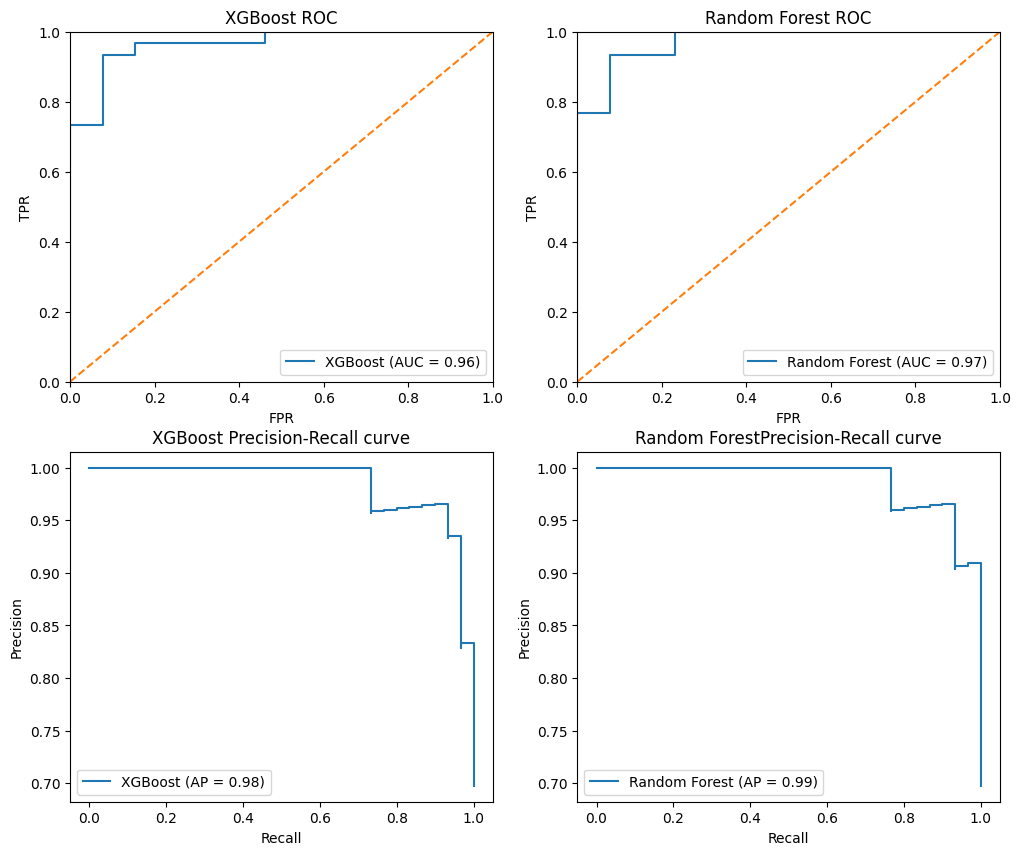

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

# Calculate and display ROC curve for classifiers:
plot_roc_curve(tuned_model, X_test, y_test, ax=axs[0, 0], name="XGBoost")
plot_roc_curve(rf_tuned_model, X_test, y_test, ax=axs[0, 1], name="Random Forest")

# Calculate and displate precision-recall curve for classifiers:
plot_precision_recall_curve(tuned_model, X_test, y_test, name="XGBoost", ax=axs[1, 0])
plot_precision_recall_curve(rf_tuned_model, X_test, y_test, name="Random Forest", ax=axs[1, 1])

# Set xlabels, ylabels, xlims, ylims and titles for all subplots:
axs[0, 0].set(xlabel="FPR", ylabel="TPR", title="XGBoost ROC", xlim=[0, 1], ylim=[0, 1])
axs[0, 1].set(xlabel="FPR", ylabel="TPR", title="Random Forest ROC", xlim=[0, 1], ylim=[0, 1])
axs[1, 0].set(xlabel="Recall", ylabel="Precision", title="XGBoost Precision-Recall curve")
axs[1, 1].set(xlabel="Recall", ylabel="Precision", title="Random Forest Precision-Recall curve")

# Plot dashed lines (random guess) for ROC curves:
axs[0, 0].plot([0,1],[0,1], "--", transform=axs[0, 0].transAxes)
axs[0, 1].plot([0,1],[0,1], "--", transform=axs[0, 1].transAxes)

plt.show()

#### 5.3) Classification Report Comparision

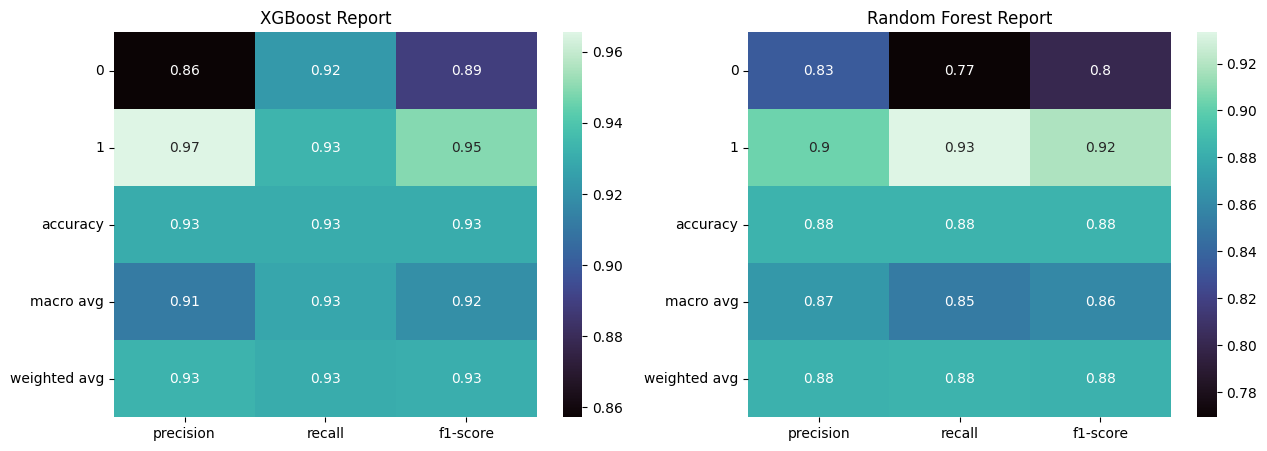

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

xgb_report = classification_report(y_test, tuned_model.predict(X_test), output_dict=True)
rf_report = classification_report(y_test, rf_tuned_model.predict(X_test), output_dict=True)

sns.heatmap(pd.DataFrame(xgb_report).iloc[:-1, :].T, annot=True, ax=axs[0], cmap="mako")
sns.heatmap(pd.DataFrame(rf_report).iloc[:-1, :].T, annot=True, ax=axs[1], cmap="mako")

axs[0].set(title="XGBoost Report")
axs[1].set(title="Random Forest Report")

plt.show()

### 6) Experiment on the least important features:

* We dropped the least important columns to see if the model will perform better.
* However, results show that the model has slightly lower performance without the least important columns.

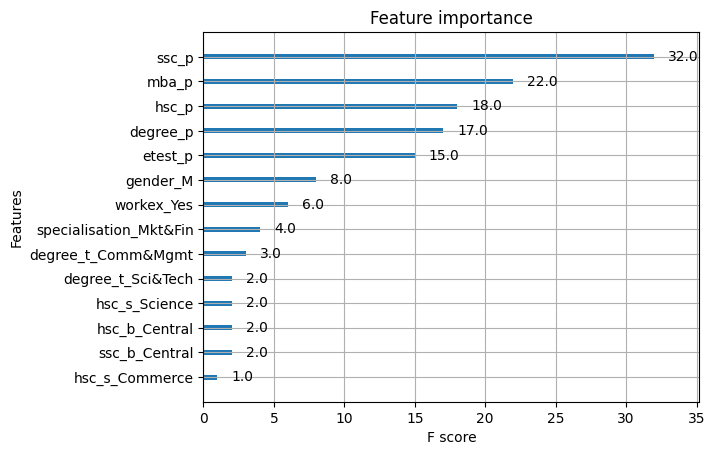

In [18]:
xgb.plot_importance(tuned_model)
plt.show()

In [19]:
# EXPERIMENTING

# feature importance
importance = tuned_model.feature_importances_

for i, feature in enumerate(X.columns):
    print(f"{feature} importance: {importance[i]}")

ssc_p importance: 0.09679501503705978
hsc_p importance: 0.07530228793621063
degree_p importance: 0.12483524531126022
etest_p importance: 0.05243841931223869
mba_p importance: 0.06282162666320801
gender_M importance: 0.05899254232645035
ssc_b_Central importance: 0.0400196835398674
hsc_b_Central importance: 0.04459872469305992
hsc_s_Arts importance: 0.0
hsc_s_Commerce importance: 0.050872523337602615
hsc_s_Science importance: 0.05765936151146889
degree_t_Comm&Mgmt importance: 0.043846238404512405
degree_t_Others importance: 0.0
degree_t_Sci&Tech importance: 0.08854668587446213
workex_Yes importance: 0.10038088262081146
specialisation_Mkt&Fin importance: 0.10289079695940018


In [22]:
X_train_new  = X_train.drop(columns=["hsc_s_Commerce", "hsc_b_Central", "ssc_b_Central", "degree_t_Sci&Tech", "degree_t_Others", "degree_t_Others", "hsc_s_Arts"])
X_test_new  = X_test.drop(columns=["hsc_s_Commerce", "hsc_b_Central", "ssc_b_Central", "degree_t_Sci&Tech", "degree_t_Others", "degree_t_Others", "hsc_s_Arts"])
y_train_new = y_train.copy()
y_test_new = y_test.copy()

# HYPER PARAMETER TUNING
param_grid = {'xgb__gamma':[0.1, 0.2, 0.4, 0.8],
              'xgb__learning_rate':[0.05, 0.075, 0.1, 0.125],
              'xgb__max_delta_step':[0, 5, 10, 20],
              'xgb__max_depth':[10, 11, 12, 13],
              'xgb__n_estimators':[100, 120, 150, 180, 200, 220],
              'xgb__subsample':[0.175, 0.2, 0.225],
              'xgb__colsample_bynode':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'xgb__colsample_bytree':[0.6, 0.7, 0.8, 0.9],
              'xgb__reg_alpha':[0, 0.1, 0.2, 0.4, 0.8],
              'xgb__reg_lambda':[0, 0.1, 0.2, 0.4, 0.8],}

gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]
bcvj = int(gcvj)

model = BayesSearchCV(estimator=xgb0, search_spaces=param_grid, n_iter=100, scoring='average_precision', cv=5, return_train_score=True, verbose=3)
model.fit(X_train_new, y_train_new)

df_new = pd.DataFrame(model.cv_results_)
bp_new = model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:28:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__colsample_bynode", "xgb__colsample_bytree", "xgb__gamma", "xgb__learning_rate", "xgb__max_delta_step", "xgb__max_depth", "xgb__n_estimators", "xgb__reg_alpha", "xgb__reg_lambda", "xgb__subsample" } are not used.

[CV 1/5] END xgb__colsample_bynode=0.6, xgb__colsample_bytree=0.9, xgb__gamma=0.2, xgb__learning_rate=0.075, xgb__max_delta_step=5, xgb__max_depth=10, xgb__n_estimators=150, xgb__reg_alpha=0.1, xgb__reg_lambda=0.2, xgb__subsample=0.225;, score=(train=1.000, test=0.933) total time=   0.0s
[12:28:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "xgb__colsample_bynode", "xgb__colsample_bytree", "xgb__gamma", "xgb__learning_rate", "xgb__max_delta_step", "xgb__max_depth"

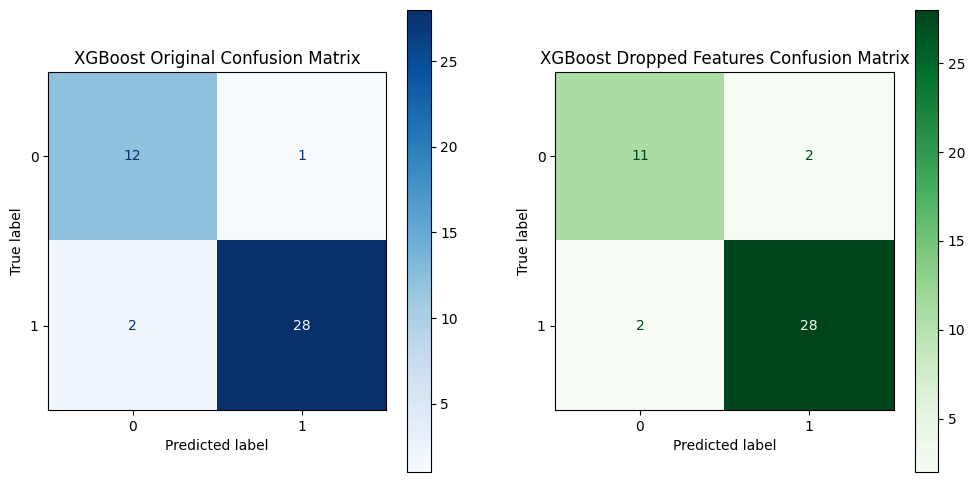

In [27]:
tuned_new_model = xgb.XGBClassifier(objective='binary:logistic',
                            booster='gbtree',
                            eval_metric='auc',
                            colsample_bynode=bp_new["xgb__colsample_bynode"],
                            colsample_bytree=bp_new["xgb__colsample_bytree"],
                            gamma=bp_new["xgb__gamma"],
                            learning_rate=bp_new["xgb__learning_rate"],
                            max_delta_step=bp_new["xgb__max_delta_step"],
                            max_depth=bp_new["xgb__max_depth"],
                            n_estimators=bp_new["xgb__n_estimators"],
                            reg_alpha=bp_new["xgb__reg_alpha"],
                            reg_lambda=bp_new["xgb__reg_lambda"],
                            subsample=bp_new["xgb__subsample"],
                            scale_pos_weight=0.45
                            )

tuned_new_model.fit(X_train_new, y_train_new)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrices:
plot_confusion_matrix(tuned_model, X_test, y_test, cmap="Blues", ax=axs[0])
plot_confusion_matrix(tuned_new_model, X_test_new, y_test_new, cmap="Greens", ax=axs[1])
axs[0].set_title("XGBoost Original Confusion Matrix")
axs[1].set_title("XGBoost Dropped Features Confusion Matrix")
plt.show()